# Machine Learning Project
**Siddh Shah, Francis Yeh, Surain Saigal, Nathan Ma**

Predicting whether packages are delivered late or not based on delivery data

In [5]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import rand
from numpy import square, sqrt
from pandas import DataFrame
%matplotlib inline

In [6]:
# First, get the data from the CSV file
df = pd.read_csv("dataset.csv")

# Drop the ID column
df = df.drop(df.columns[0], axis=1)

df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,D,Flight,4,2,177,3,low,F,44,1233,1
1,F,Flight,4,5,216,2,low,M,59,3088,1
2,A,Flight,2,2,183,4,low,M,48,3374,1
3,B,Flight,3,3,176,4,medium,M,10,1177,1
4,C,Flight,2,2,184,3,medium,F,46,2484,1


# Some Data Visualization

We are trying to predict the value of Reached.on.Time_Y.N based on the other features. In other words, we want to build a binary classification model that is trying to classify whether a certain package reached it's destination on time.

In [7]:
features = df.drop(["Reached.on.Time_Y.N"], axis=1)
labels = df["Reached.on.Time_Y.N"]
features = pd.get_dummies(features, columns=["Warehouse_block", "Mode_of_Shipment", "Product_importance"])
features.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Gender,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium
0,4,2,177,3,F,44,1233,False,False,False,True,False,True,False,False,False,True,False
1,4,5,216,2,M,59,3088,False,False,False,False,True,True,False,False,False,True,False
2,2,2,183,4,M,48,3374,True,False,False,False,False,True,False,False,False,True,False
3,3,3,176,4,M,10,1177,False,True,False,False,False,True,False,False,False,False,True
4,2,2,184,3,F,46,2484,False,False,True,False,False,True,False,False,False,False,True


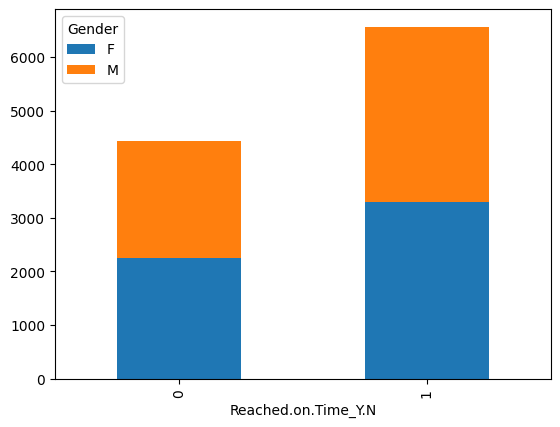

Chi-squared statistic: [0.86654644 0.12814262]
p-value: [0.35191318 0.72036566]


In [8]:
from scipy.stats import chisquare

gender_vs_time = df.groupby(['Gender', 'Reached.on.Time_Y.N']).size().unstack().T


gender_vs_time.plot(kind='bar', stacked=True)

# Display the graph
plt.show()

#probably drop gender, roughly equal

tab = pd.crosstab(df['Gender'], df['Reached.on.Time_Y.N'])

chi, p_value = chisquare(tab)

print("Chi-squared statistic:", chi)
print("p-value:", p_value)

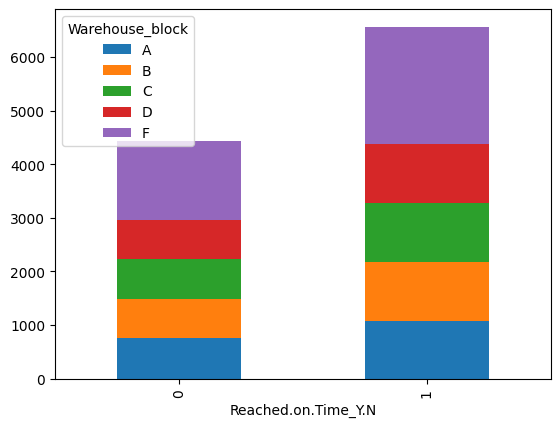

Chi-squared statistic: [482.34310189 740.16090203]
p-value: [4.41214072e-103 7.00761672e-159]


In [9]:
ware_vs_time = df.groupby(['Warehouse_block', 'Reached.on.Time_Y.N']).size().unstack().T


ware_vs_time.plot(kind='bar', stacked=True)

# Display the graph
plt.show()

tab = pd.crosstab(df['Warehouse_block'], df['Reached.on.Time_Y.N'])

chi, p_value = chisquare(tab)

print("Chi-squared statistic:", chi)
print("p-value:", p_value)

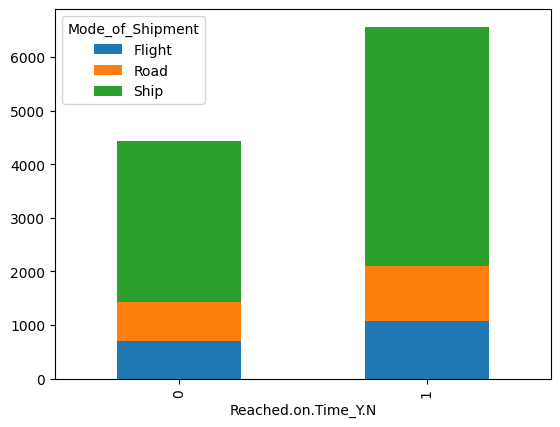

Chi-squared statistic: [2357.21325518 3537.56391894]
p-value: [0. 0.]


In [10]:
mode_vs_time = df.groupby(['Mode_of_Shipment', 'Reached.on.Time_Y.N']).size().unstack().T


mode_vs_time.plot(kind='bar', stacked=True)

# Display the graph
plt.show()

tab = pd.crosstab(df['Mode_of_Shipment'], df['Reached.on.Time_Y.N'])

chi, p_value = chisquare(tab)

print("Chi-squared statistic:", chi)
print("p-value:", p_value)

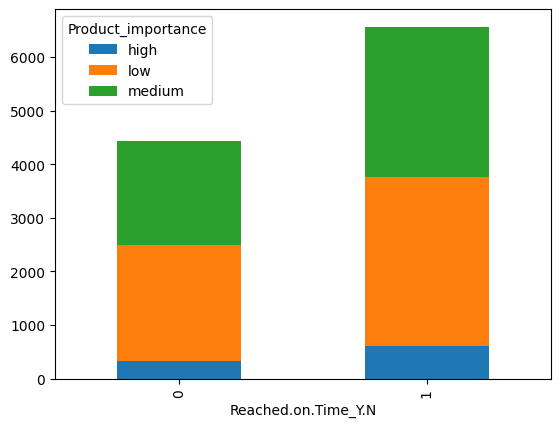

Chi-squared statistic: [1348.72633003 1719.02270303]
p-value: [1.34214252e-293 0.00000000e+000]


In [11]:
importance_vs_time = df.groupby(['Product_importance', 'Reached.on.Time_Y.N']).size().unstack().T
importance_vs_time.plot(kind='bar', stacked=True)

# Display the graph
plt.show()

tab = pd.crosstab(df['Product_importance'], df['Reached.on.Time_Y.N'])

chi, p_value = chisquare(tab)

print("Chi-squared statistic:", chi)
print("p-value:", p_value)

# Feature Selection and Engineering
Based on the data visualization, we decided to drop the Gender, Customer rating, Customer care calls, and prior purchases columns as they didn't have high statistical significance when related to Reached.on.Time_Y.N (our class label).

In [12]:
#Dropping Gender, Customer Rating, Customer_care_calls, Prior Purchases
df = df.drop(["Gender", "Customer_rating", "Customer_care_calls", "Prior_purchases"], axis=1)
df.head()

,Warehouse_block,Mode_of_Shipment,Cost_of_the_Product,Product_importance,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,D,Flight,177,low,44,1233,1
1,F,Flight,216,low,59,3088,1
2,A,Flight,183,low,48,3374,1
3,B,Flight,176,medium,10,1177,1
4,C,Flight,184,medium,46,2484,1


We need to split the data into features and labels. We decided to label-encode the categorical features, rather than one-hot encode, to avoid the curse of dimensionality that could arise from adding more columns.

When encoding categorical feautures, many ML algorithms require the input to be numeric. Because of this, we need a converter. "LabelEncoder" will convert categorical labels into a numerical format. Each unique category in a column is assigned a numerical id. This process is applied to all columns that are of object type (typically strings or categories). This is a crucial step because it turns the data into a suitable format for training ML models.

In [13]:
from sklearn.preprocessing import LabelEncoder

# Initialize a LabelEncoder
le = LabelEncoder()

# Apply the LabelEncoder to each column of df that has object dtype
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

features = df.drop(["Reached.on.Time_Y.N"], axis=1)
labels = df["Reached.on.Time_Y.N"]

features.head()

,Warehouse_block,Mode_of_Shipment,Cost_of_the_Product,Product_importance,Discount_offered,Weight_in_gms
0,3,0,177,1,44,1233
1,4,0,216,1,59,3088
2,0,0,183,1,48,3374
3,1,0,176,2,10,1177
4,2,0,184,2,46,2484


# Anomaly Detection

Anamoly Detection is used to eliminate "anamolies" in the records in hopes to present the best training set and increase the accuracy. 

In [50]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.01), random_state=42)
pred = clf.fit_predict(df[['Cost_of_the_Product', 'Weight_in_gms']])
df['anomaly'] = pred
outliers = df[df['anomaly'] == -1]

print("Number of Anomaly Rows: ", len(outliers))

Number of Anomaly Rows:  110


Since our dataset is very large (11000 rows), losing 110 of them will likely not have a huge impact on performance. However, we will still drop the rows since they likely reflect errors in the real world data and could be adding unneccessary noise and bias to our models. 

In [52]:
# Drop anomalous rows

anomaly_indices = df[df['anomaly'] == -1].index
df = df.drop(anomaly_indices)

features = df.drop(["Reached.on.Time_Y.N", "anomaly"], axis=1)
labels = df["Reached.on.Time_Y.N"]

print("Number of Rows after dropping anomalies: ", len(df))

Number of Rows after dropping anomalies:  10889


# Training the Models
Our group decided that we would train 4 different models (KNN, SVM, Neural Network, Naive Bayes) to see which would perform best on our dataset. If all come out with relatively good accuracies, the plan is to heterogeneously ensemble them to achieve an even higher performance.

# KNN Model

In [53]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns

KNN Mean Accuracy:  0.6512994765359538
KNN Classification Report: 
               precision    recall  f1-score   support

           0       0.55      0.73      0.63      4405
           1       0.76      0.60      0.67      6484

    accuracy                           0.65     10889
   macro avg       0.66      0.66      0.65     10889
weighted avg       0.68      0.65      0.65     10889



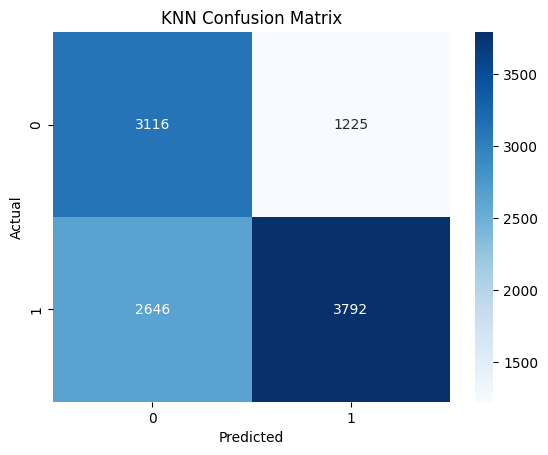

In [54]:

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])


# Define the parameters to test w/ nested CV
param_grid = {'knn__n_neighbors': [2, 3, 5, 7, 9, 12], 'knn__weights': ['uniform', 'distance'], 'pca': [None, PCA(n_components=0.8), PCA(n_components=0.85), PCA(n_components=0.9), PCA(n_components=0.95)]}

# Both CV folds
outer_cv = StratifiedKFold(n_splits=5, shuffle=True)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True)

# Get nested CV score
grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='accuracy')
predictions = cross_val_predict(grid_search, features, labels, cv=outer_cv)

accuracy = accuracy_score(labels, predictions)
print("KNN Mean Accuracy: ", accuracy)

print("KNN Classification Report: \n", classification_report(labels, predictions))

conf_matrix = pd.crosstab(pd.Series(labels, name='Actual'), pd.Series(predictions, name='Predicted'), rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("KNN Confusion Matrix")
plt.show()


In [55]:
from sklearn.metrics import accuracy_score
#60% isn't that great... but that's okay
grid_search.fit(features, labels)

# Obtain the best estimator (final model) from the grid search object
best_model = grid_search.best_estimator_

label_pred = best_model.predict(features)

accuracy = accuracy_score(labels, label_pred)

print("Accuracy on the entire dataset:", accuracy)

Accuracy on the entire dataset: 0.719441638350629


# Naïve Bayes

First, we have to import the necessary libraries for this approach to work

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

Naive Bayes Accuracy: 0.65 (+/- 0.01)
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.97      0.69      4405
           1       0.95      0.43      0.59      6484

    accuracy                           0.65     10889
   macro avg       0.74      0.70      0.64     10889
weighted avg       0.78      0.65      0.63     10889



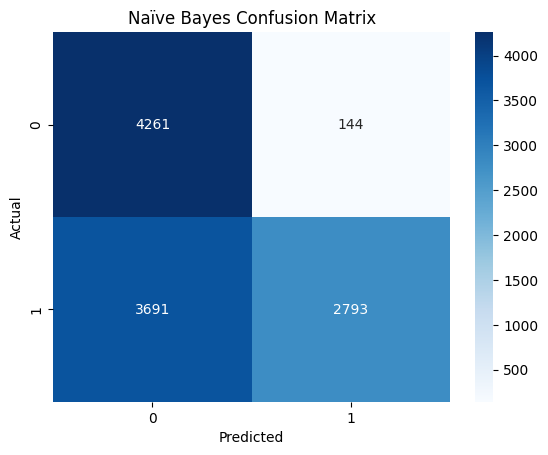

In [58]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=768)

naive = GaussianNB()

# cross-validation
scores = []
val_labels, val_predictions = [], []
for train_index, val_index in kfold.split(features, labels):
    # Get the training and validation data
    features_train, features_val = features.iloc[train_index], features.iloc[val_index]
    labels_train, labels_val = labels.iloc[train_index], labels.iloc[val_index]

    # Fit the classifier on the training data
    naive.fit(features_train, labels_train)

    # Make predictions on the validation data
    predictions = naive.predict(features_val)
    val_labels.extend(labels_val)
    val_predictions.extend(predictions)

    # Calculate the accuracy of the classifier on the validation data
    score = accuracy_score(labels_val, predictions)
    scores.append(score)
print("Naive Bayes Accuracy: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))

# Display the classification report
print("Classification Report:")
print(classification_report(val_labels, val_predictions))

conf_matrix = pd.crosstab(pd.Series(val_labels, name='Actual'), pd.Series(val_predictions, name='Predicted'), rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Naïve Bayes Confusion Matrix")
plt.show()


# Standard Vector Machine (SVM)

In [21]:
from sklearn import svm

In [59]:
model = svm.SVC()
scaler = StandardScaler()
pca = PCA()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=768)


pipeline = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('svm', model)
])

param_grid = {
    'pca__n_components': range(2, 6),
    'svm__kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='accuracy')

predictions = cross_val_predict(grid_search, features, labels, cv=kfold)

SVM Mean Accuracy:  0.6640646524015061
SVM Classification Report: 
               precision    recall  f1-score   support

           0       0.56      0.78      0.65      4405
           1       0.80      0.58      0.67      6484

    accuracy                           0.66     10889
   macro avg       0.68      0.68      0.66     10889
weighted avg       0.70      0.66      0.67     10889



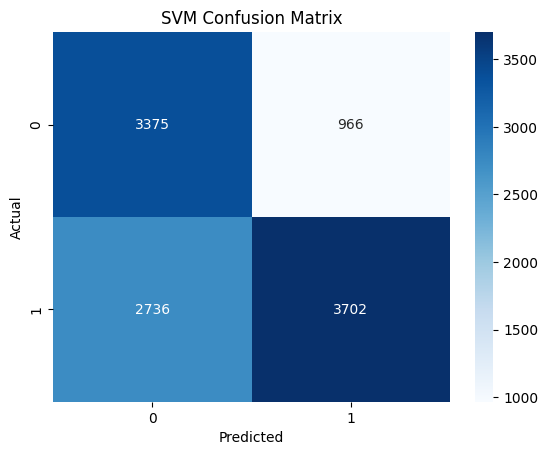

In [60]:
accuracy = accuracy_score(labels, predictions)
print("SVM Mean Accuracy: ", accuracy)

print("SVM Classification Report: \n", classification_report(labels, predictions))

conf_matrix = pd.crosstab(pd.Series(labels, name='Actual'), pd.Series(predictions, name='Predicted'), rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.show()

# Neural Network

After attempting to use sklearn's MLPC classifier, we found that the accuracy was poor and sklearn's lack of optimization made the process very long with the size of our dataset. We decided to explore tensorflow and got better, and faster, results.

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import keras_tuner as kt
import tensorflow as tf

The function below is used to test hyperparameters on the deep learning sequential neural net. The hyperparameters tested were the number of hidden layers, number of nodes per layer, the activation function, the dropout rate, and the learning rate.

In [62]:
def tf_hyperparam_model(hp):
    model = Sequential()

    # hyperparameter: units per layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)

    # hyperparameter: number of hidden layers
    hp_num_layers = hp.Int('num_layers', min_value=1, max_value=5, step=1)

    # hyperparameter: activation function
    hp_activation = hp.Choice('activation_function', values=['relu', 'tanh', 'sigmoid'])

    # hyperparameter: dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.05, max_value=0.5, step=0.05)

    model.add(Input(shape=(6,)))
    for _ in range(hp_num_layers):
        model.add(Dense(units=hp_units, activation=hp_activation))
        model.add(Dropout(hp_dropout))
        model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    # hyperparameter: learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    

    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])
    return model

The function below utilizes the model above to test hyperameters with a training and validation set. To speed this process up, we utilized Tensorflow's Hyperband tuning algorithm, which "uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round." 

This is a much more efficient way to converge on the best hyperparameters, and beats other methods like grid search by miles.

In [63]:
def tf_hyperparam_tester():
    # Split the data into training and validation sets
    features_train, features_val, labels_train, labels_val = train_test_split(features, labels, test_size=0.2, random_state=42, shuffle=True)

    # Scale the training features
    scaler_train = StandardScaler()
    features_train_scaled = scaler_train.fit_transform(features_train)

    # Scale the validation features
    scaler_val = StandardScaler()
    features_val_scaled = scaler_val.fit_transform(features_val)

    tuner = kt.Hyperband(tf_hyperparam_model,
                        objective='val_accuracy',
                        max_epochs=10,
                        factor=3)

    # search for the best hyperparameters
    tuner.search(features_train_scaled, labels_train, 
                 validation_data=(features_val_scaled, labels_val), 
                 epochs=50, batch_size=64)

    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
    return best_hps

best_hps = tf_hyperparam_tester()
print("Best hyperparameters:", best_hps.values)


Trial 30 Complete [00h 00m 25s]
val_accuracy: 0.6528925895690918

Best val_accuracy So Far: 0.6818181872367859
Total elapsed time: 00h 03m 35s
Best hyperparameters: {'units': 448, 'num_layers': 2, 'activation_function': 'relu', 'dropout': 0.4, 'learning_rate': 0.01, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}


Based on the results above, the best performing hyperparameters on the model were 2 hidden layers with 448 nodes per layer, the 'relu' activation function, a dropout rate of 0.4, and a learning rate of 0.01.

We will run cross validation to get a final accuracy score on a model with these hyperparameters.

In [64]:
# build a neural network with the optimal hyperparameters

def tf_model(num_layers, num_units, dropout, activation_fn, learning_rate):
    model = Sequential()

    model.add(Input(shape=(6,)))
    for _ in range(num_layers):
        model.add(Dense(units=num_units, activation=activation_fn))
        model.add(Dropout(dropout))
        model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=['accuracy'])
    return model

def tf_model_cross_validate(num_layers, num_units, dropout, activation_fn, learning_rate):
    scaler = StandardScaler()
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=768)
    nn = KerasClassifier(model=tf_model(num_layers, num_units, dropout, activation_fn, learning_rate), epochs=100, batch_size=128, verbose=0)
    pipe = Pipeline(steps=[('scaler', scaler), ('nn', nn)])

    predictions = cross_val_predict(pipe, features, labels, cv=kfold)
    return predictions

print("Best hyperparameters found using Hyperband technique:", best_hps.values)
print("Running cross val with best hyperparameters...")
predictions = tf_model_cross_validate(best_hps.values['num_layers'], best_hps.values['units'], best_hps.values['dropout'], best_hps.values['activation_function'], best_hps.values['learning_rate'])

Best hyperparameters found using Hyperband technique: {'units': 448, 'num_layers': 2, 'activation_function': 'relu', 'dropout': 0.4, 'learning_rate': 0.01, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}
Running cross val with best hyperparameters...


/usr/local/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the save

Neural Net Mean Accuracy:  0.681972632932317
Neural Net Classification Report: 
               precision    recall  f1-score   support

           0       0.56      0.96      0.71      4405
           1       0.95      0.49      0.65      6484

    accuracy                           0.68     10889
   macro avg       0.76      0.73      0.68     10889
weighted avg       0.79      0.68      0.67     10889



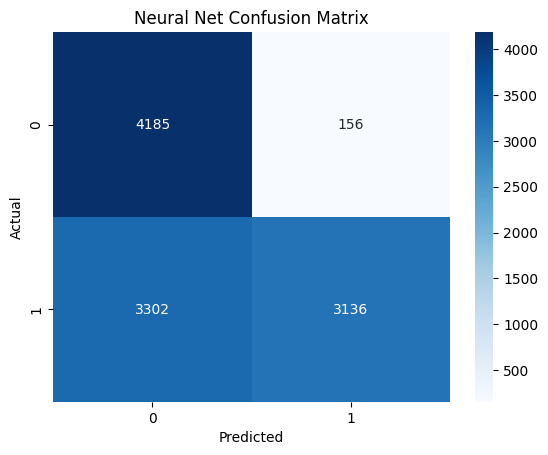

In [65]:
accuracy = accuracy_score(labels, predictions)
print("Neural Net Mean Accuracy: ", accuracy)

print("Neural Net Classification Report: \n", classification_report(labels, predictions))

conf_matrix = pd.crosstab(pd.Series(labels, name='Actual'), pd.Series(predictions, name='Predicted'), rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Neural Net Confusion Matrix")
plt.show()

After all this work, the resulting accuracy on the neural net is less than hoped for. However, after doing more research I found that tensorflows neural nets are better suited to tasks such as image classification. Perhaps a different technique suited to tabular data, like XGBoost, would have been a better choice.

# Ensembling the Models